# Spiking-Phasor VSA: LDN
Purpose: to have a spiking-phasor implementation of a Legendre Delay Network (LDN).

## Prelims

In [1]:
from numpy import *
from matplotlib.pyplot import *
from tqdm import tqdm
from phasorutils import *
from brian2 import *
from numpy import *
from matplotlib.pyplot import *
from scipy.integrate import solve_ivp
from scipy.linalg import expm, inv
from spikingVSA import *
from copy import deepcopy

### Signal to store

In [2]:
def mysig(t, c, pause):
    L = 7.
    v = zeros_like(t)
    mask = t>=pause
    v = c[0]*sin((t-pause)*2*pi/L) * mask
    for k,cc in enumerate(c[1:]):
        v += cc*sin(2*k*(t-pause)*2*pi/L) * mask
    return array(v)

In [3]:
freq = 10.
T = 2.  # simulation time
ttvals = arange(0, T, 1./freq/10.)

c = random.normal(size=(7,))/2.
print(c)
sig = lambda t: mysig(t,c,0.2)

[-0.09715533 -0.04204689 -0.24322221  0.5066823   0.37510211  0.45327696
 -0.45567559]


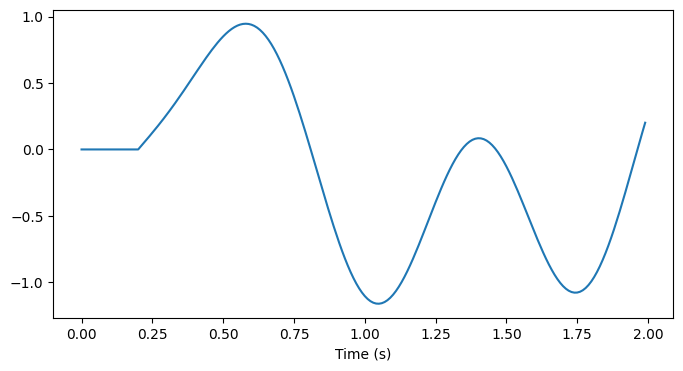

In [4]:
figure(figsize=(8,4))
plot(ttvals, sig(ttvals));
xlabel('Time (s)');
savefig('signal.pdf');

## `LMU` class
This class constructs the collection of populations that encode the Legendre Memory Unit (LMU) coefficients.

In [5]:
class LMU(SpikingPop):
    def __init__(self, C, d=5, theta_max=1., freq=5.):
        '''
         L = LMU(C, d=5, freq=5.)
         
         Creates an LMU network of dimension d. It creates d integrators
         that encode the d coefficients using SSPs.
         
         Inputs:
          C          complex array, axis vector for SSPs
          d          positive integer
          theta_max  length of the recorded history
          freq       frequency of the spiking phasors
        '''
        super().__init__()
        self.S = C
        self.d = d
        self.theta_max = theta_max
        self.N = len(self.S)
        self.freq = freq
        self.period = 1./self.freq
        self.makeAB()
        self.symbols = {}
        
        # Create the integrator population
        self.m = []
        self.br = []
        self.symbols = {}
        self.pops = []
        for dd in range(self.d):
            m = SPIntegrator(N=self.N, freq=self.freq)
            self.m.append(m)
            self.br.append(m.br)
            self.symbols.update(m.symbols)
            self.pops.append(m.G)
        
            
    def total_neurons(self):
        tot = 0
        for mm in self.m:
            tot += mm.total_neurons()
        return tot
        
    def makeAB(self):
        d = self.d
        self.A = np.zeros((d,d), dtype=float)
        self.B = np.zeros(d, dtype=float)
        for i in range(d):
            self.B[i] = (2*i+1)*(-1)**i
            for j in range(d):
                self.A[i,j] = (2*i+1)
                if i<j:
                    self.A[i,j] *= -1
                else:
                    self.A[i,j] *= (-1)**(i-j+1)
        self.A /= self.theta_max
        self.B /= self.theta_max
        self.Ad = expm(self.A*self.period) - eye(self.d)
        self.Bd = inv(self.A) @ ( self.Ad @ self.B )

    def spike_raster(self, offset=0, color=None):
        total_N = 0.
        for m in self.m:
            total_N += m.spike_raster(offset=offset+total_N, color=color)
        return total_N


## Run LMU

In [6]:
N = 50
freq = 40.
d = 10
theta_max = 1.
T = 2.
ds = SparsePhaseMap(M=1, N=N, sparsity=1.)
reset_time = 1./freq

In [7]:
def MyEuler(f, tspan, y0, input_function, N=100):
    '''
    t,y = MyEuler(f, tspan, y0, N=100)
    
    Use Euler's method to approximate the solution of y' = f(t,y).
    
     Input
       f  is the handle to a Matlab dynamics function with calling sequence
            dydt = f(t, y)
       tspan is a 1x2 vector, [start end]
       y0 is the initial state of the system
       N is the number of steps to take

     Output
       t and y are column vectors of the same length.
    '''

    # Initialize output arrays
    t = np.linspace(tspan[0], tspan[1], N+1)
    h = t[1] - t[0]  # step size
    z = [y0]
    
    zz = y0
    for tt in t[:-1]:
        zz = zz + h * f(tt, zz, input_function)
        z.append(zz)

    return t, np.array(z)

In [8]:
# Original formulation using Padé
class myLMU():
    def __init__(self, d, theta_max=1., dt=0.1):
        '''
         lmu = myLMU(d, theta_max=1., dt=0.1)
         
         Creates an LMU object with dimension d.
         dt is the time step for Euler's method.
         
         This is the original formulation in
         Aaron Voelker's PhD thesis.
        '''
        self.d = d
        self.theta_max = theta_max
        self.dt = dt
        
        # Construct system matrices
        self.makeAB()
        
    def makeAB(self):
        d = self.d
        self.A = np.zeros((d,d), dtype=float)
        self.B = np.zeros(d, dtype=float)
        for i in range(d):
            self.B[i] = (2*i+1)*(-1)**i
            for j in range(d):
                self.A[i,j] = (2*i+1)
                if i<j:
                    self.A[i,j] *= -1
                else:
                    self.A[i,j] *= (-1)**(i-j+1)
        self.A /= self.theta_max
        self.B /= self.theta_max
    
    def de(self, t, z, u):
        return (self.A@z + u(t)*self.B)
        #return u(t)*self.B
    
    def decode(self, thetap, m):
        val = np.zeros_like(thetap)
        for i in range(d):
            val = val + myLMU.LegendrePoly(i, thetap) * m[i]
        return val
    
    @classmethod
    def LegendrePoly(cls, i, t):
        r = np.array(t)
        tot = np.zeros_like(r)
        for j in range(i+1):
            blah = math.comb(i,j) * math.comb(i+j,j)*(-r)**j
            #print(tot.dtype)
            tot = tot + blah
        return tot*(-1)**i

In [9]:
# Formulation of LMU, using linear state space model
# https://en.wikipedia.org/wiki/Discretization#Discretization_of_linear_state_space_models
class myLMU():
    def __init__(self, d, theta_max=1., dt=0.1):
        '''
         lmu = myLMU(d, theta_max=1., dt=0.1)
         
         Creates an LMU object with dimension d.
         dt is the time step for Euler's method.
         
         !! Uses the DE solution in each step. !!
        '''
        self.d = d
        self.theta_max = theta_max
        self.dt = dt
        
        # Construct system matrices
        self.makeAB()
        
    def makeAB(self):
        d = self.d
        self.A = np.zeros((d,d), dtype=float)
        self.B = np.zeros(d, dtype=float)
        for i in range(d):
            self.B[i] = (2*i+1)*(-1)**i
            for j in range(d):
                self.A[i,j] = (2*i+1)
                if i<j:
                    self.A[i,j] *= -1
                else:
                    self.A[i,j] *= (-1)**(i-j+1)
        self.A /= self.theta_max
        self.B /= self.theta_max
        # Next 2 lines are essentially solving the linear DEs for 1 time step.
        self.Ad = expm(self.A*self.dt) - eye(self.d)
        self.Bd = inv(self.A) @ ( self.Ad @ self.B )
    
    def de(self, t, z, u):
        return (self.Ad@z + u(t)*self.Bd) / self.dt
        #return u(t)*self.B
    
    def decode(self, thetap, m):
        val = np.zeros_like(thetap)
        for i in range(d):
            val = val + myLMU.LegendrePoly(i, thetap) * m[i]
        return val
    
    @classmethod
    def LegendrePoly(cls, i, t):
        r = np.array(t)
        tot = np.zeros_like(r)
        for j in range(i+1):
            blah = math.comb(i,j) * math.comb(i+j,j)*(-r)**j
            #print(tot.dtype)
            tot = tot + blah
        return tot*(-1)**i

In [10]:
m0 = np.zeros(d)
tspan = [0, 2]

# Use the Euler-friendly LMU formulation
lmu = myLMU(d, theta_max=theta_max, dt=1./freq)

esol = MyEuler(lmu.de, tspan, m0, sig, N=int(tspan[1]*freq))

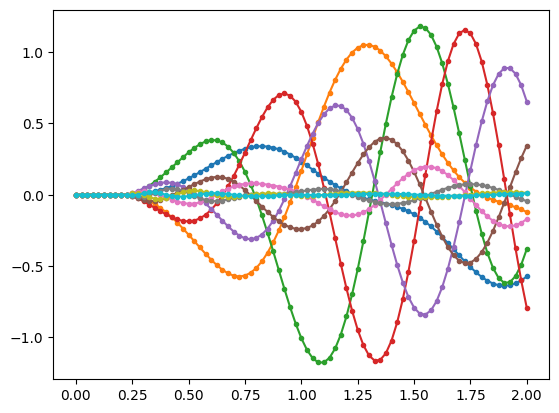

In [11]:
plt.plot(esol[0], esol[1], '.-');

In [12]:
M = 1
N = 100      # dim of hypervectors
freq = 40.   # choosing a higher cycle frequency, 40Hz
ds = SparsePhaseMap(M=M, N=N, sparsity=1.)

In [13]:
net = SpikingPhasorNet()

# Input signal
inp = GenerateSP(N=N, C=ds.S[0], freq=freq); net.add_pop(inp)
V = PhaseMultPop(N=N, freq=freq); net.add_pop(V)
net.fractional_bind(inp, V, 0.)  # synapse 0

# LMU
y = LMU(C=ds.S[0], d=d, theta_max=1., freq=freq); net.add_pop(y)
net.connect_to_lmu(V, y)  # creates a bunch of integration connections

# The reset neuron sends a single spike at t=0
reset_neuron = GenerateSpikes(N=1, indices=[0], times=[reset_time]); net.add_pop(reset_neuron)
net.reset(reset_neuron, y)  # sets encoded values to 0 in the LMU

# This function is used to update the v encoded in population V
# once every ms.
def update_input(t):
    v = sig(t/second)
    setattr(net.syns[0].br, net.syns[0].alpha_id, v)

net.br.add(NetworkOperation(update_input, dt=1.*ms))

In [14]:
net.total_neurons()

1201

In [15]:
defaultclock.dt = 0.1*ms
net.run(T*second)

WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. Abstract code: 'th_post = (-0.5) + ((0.5 + (x_post * alpha311)) % 1)'
 [brian2.codegen.generators.base]


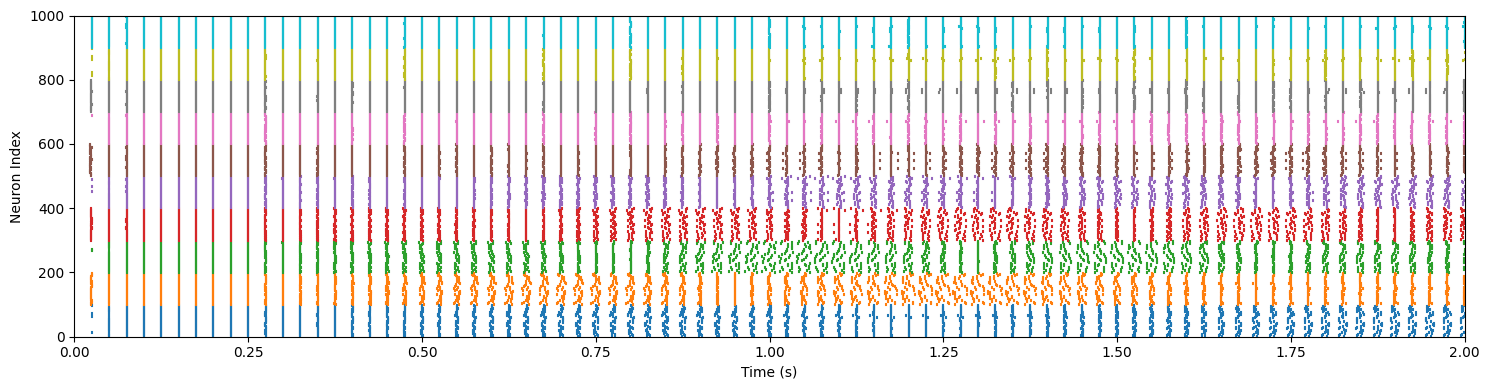

In [16]:
import matplotlib.colors
colours = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
           'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
figure(figsize=(15,4))
offset = 0
for k,mm in enumerate(y.m):
    blah = mm.spike_raster(offset=offset, color=colours[k])
    offset += blah
#xticks([]); yticks([]);
xlim(0,T); ylim(0,offset);
axlims = axis();
xlabel('Time (s)');
tight_layout();
#savefig('lmu_spikes2.pdf');

## Decode the LMU coefs, just for fun

In [17]:
d_plot = d
f_all = []
for dd in range(d_plot):
    f,f_tvals = y.m[dd].decode_xt(ds.S[0], [-2, 2.], [reset_time, T])
    f_all.append(f)
f_all = array(f_all)

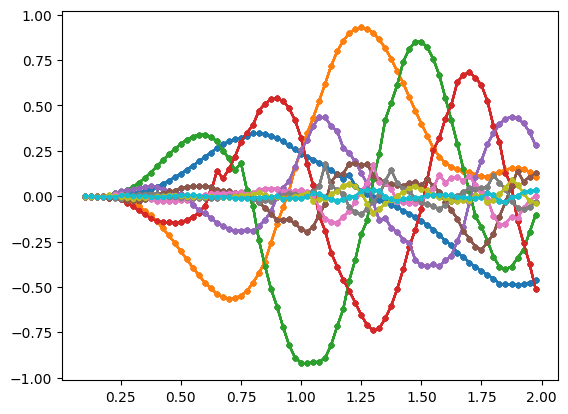

In [18]:
for dd in range(d):
    plot(f_tvals[3:], f_all.T[3:], '.-');

### Superimpose Raster with Coefs

<Figure size 700x300 with 0 Axes>

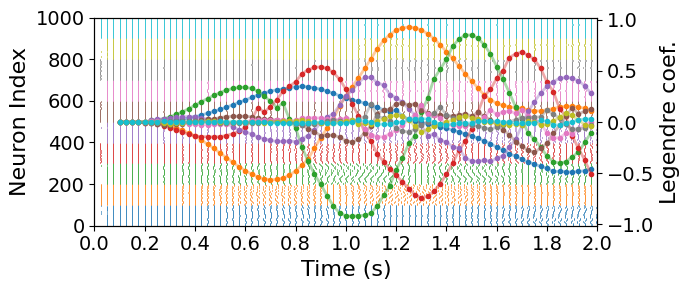

In [29]:
import matplotlib.colors
colours = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
           'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
#figure(figsize=(15,4))
figure(figsize=(7,3))
fig,ax = subplots(1, 1, figsize=(7,3))
offset = 0
for k,mm in enumerate(y.m):
    blah = mm.spike_raster(offset=offset, color=colours[k], lw=0.5)
    offset += blah

ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xticks([]);
ax.set_xlabel('Time (s)', fontsize=16);
ax.set_xlim(0,T); ax.set_ylim(0,offset);
ax.set_ylabel('Neuron Index', fontsize=16)

d_plot = d
ax2 = ax.twinx()
for dd in range(d_plot):
    ax2.plot(f_tvals[3:], f_all[dd][3:], '-', lw=2, color=colours[dd], alpha=0.4);
    ax2.plot(f_tvals[3:], f_all[dd][3:], '.', color=colours[dd], alpha=1, ms=6);

ax2.set_ylabel('Legendre coef.', fontsize=16)
ax2.set_xticks([]);

xticks(arange(0,T+0.0001,0.2)); #grid('on');
axlims = axis();
ax2.tick_params(axis='both', which='major', labelsize=14)
tight_layout();
savefig('lmu_spikes2.pdf');

## Plot delayed signals, as proof of concept
Purpose: The population y.m[k] stores the k-th Legendre coefficient as a spiking-phasor hypervector (SSP). All the coefficients together encode a function on $\theta \in [0,T]$, which represents the previous $T$ seconds of input.

### Functions to decode LMU

In [20]:
def M2SSP(M, theta):
    '''
     H = M2SSP(M, theta)
     Converts an array of complex SSPs (encoding Legendre coefs) to a single
     SSP that stores the value of the resulting Legendre polynomial at
     theta, P(theta).
     
     Inputs:
      M      (d, N) complex array storing d Legendre coefs as N-D SSPs
      theta  scalar in the range [0,T]
      
     Output:
      H      complex N-vector storing the value of the Legendre polynomial
             at theta, P(theta).
    '''
    H = ones((N,), dtype=csingle)
    for k,mm in enumerate(M):
        mask = abs(mm)>1e-5
        H[mask] *= mm[mask]**(myLMU.LegendrePoly(k,theta))
    return H

In [21]:
def complex_spatial_similarity(v, S, xvals):
    Sx = []
    for x in xvals:
        Sx.append(S**x)
    Sx = array(Sx)

    max_i, sims = complex_similarity(v, Sx)
    return max_i, sims

In [22]:
# Construct Mt, the (d,N) matrix of complex SSPs.
# Each row holds a complex SSP that stores 1 Legendre coefficient.
def LMU2complex(y, t):
    '''
     M = LMU2complex(lmu, t)
     Converts the LMU object into an array of complex vectors based on their
     spike phase from [t, t+L], where L is the period.
     M is a (d,N) matrix.
    '''
    Mt = []
    for mm in y.m:
        Mt.append(mm.spikes2complex(t))
    return array(Mt)

In [23]:
def decode_lmu(y, S, t, theta):
    '''
    p = decode_lmu(y, S, t, theta)
    Decodes the LMU stored in the object y, at time t, with a delay
    of theta. S is the axis vector for the SSPs.
    '''
    M = LMU2complex(y, t)
    H = M2SSP(M, theta)
    xvals = linspace(-3., 3, 601)
    max_i, sims = complex_spatial_similarity(H, S, xvals)
    return xvals[max_i]

### Results

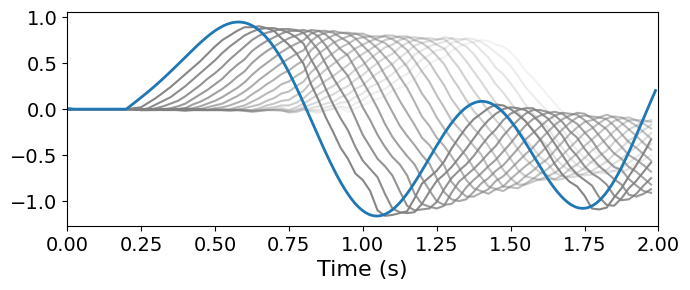

In [27]:
figure(figsize=(7,3))

for theta in arange(0.05, 0.95, 0.05):
    p = []
    tvals = arange(0, T, 1./freq)
    for tt in tvals:
        p.append(decode_lmu(y, ds.S[0], tt, theta))
    p = array(p)

    plot(tvals, p, color=(0.5,0.5,0.5,1-theta));

plot(ttvals, sig(ttvals), lw=2)
xlim(axlims[0], axlims[1]);
gca().tick_params(axis='both', which='major', labelsize=14)
xlabel('Time (s)', fontsize=16);
tight_layout();
savefig('splmu_plots.pdf');